In [1]:
# [CELL 1] SETUP MÔI TRƯỜNG & HYPERPARAMETERS
# ---------------------------------------------------------
# Import các thư viện cần thiết và thiết lập các tham số siêu (hyperparameters)
# cho thuật toán Di truyền (GA). Tại đây, bạn có thể điều chỉnh số lượng thành phố,
# kích thước quần thể, và số thế hệ để kiểm tra hiệu năng.

import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time

# =========================
# CONFIG - OPTIMIZED FOR SPEED
# =========================
NUM_CITIES = 100
POP_SIZE = 400
GENERATIONS = 2000
MUTATION_RATE = 0.02
TOURNAMENT_SIZE = 4
CROSSOVER_RATE = 0.95
REPLACEMENT_RATE = 0.2
ELITISM_RATE = 0.05

# Cache cho distance calculation để tăng tốc độ
distance_cache = {}

In [2]:
# [CELL 2] ĐỊNH NGHĨA CLASS CITY & HÀM MỤC TIÊU (FITNESS FUNCTION)
# ---------------------------------------------------------
# Định nghĩa đối tượng Thành phố và hàm tính khoảng cách Euclidean.
# Sử dụng kỹ thuật Caching (distance_cache) để giảm thiểu chi phí tính toán lặp lại,
# giúp thuật toán chạy nhanh hơn đáng kể.

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.id = id(self)

    def distance(self, city):
        key = (min(self.id, city.id), max(self.id, city.id))
        if key not in distance_cache:
            distance_cache[key] = np.sqrt((self.x - city.x)**2 + (self.y - city.y)**2)
        return distance_cache[key]

    def __repr__(self):
        return f"({self.x},{self.y})"

def total_distance(route):
    """Hàm mục tiêu: Tính tổng quãng đường của một lộ trình"""
    return sum(route[i].distance(route[i+1]) for i in range(len(route)-1)) + route[-1].distance(route[0])

In [3]:
# [CELL 3] KHỞI TẠO QUẦN THỂ & HEURISTIC (NEAREST NEIGHBOR)
# ---------------------------------------------------------
# Tạo quần thể ban đầu. Chúng ta sử dụng thuật toán tham lam (Nearest Neighbor)
# để tạo ra 1 cá thể "khá tốt" ban đầu (Seeding), giúp GA định hướng tốt hơn.
# Các cá thể còn lại được tạo ngẫu nhiên hoàn toàn.

def tsp_nearest_neighbor(cities):
    """Nearest Neighbor algorithm (Thuật toán tham lam)"""
    unvisited = cities.copy()
    route = [unvisited.pop(0)]
    while unvisited:
        last = route[-1]
        next_city = min(unvisited, key=lambda c: last.distance(c))
        unvisited.remove(next_city)
        route.append(next_city)
    return route

def createRoute(cityList):
    """Tạo một lộ trình ngẫu nhiên"""
    return random.sample(cityList, len(cityList))

def initialPopulation(popSize, cityList):
    """Khởi tạo quần thể: bao gồm 1 cá thể từ Nearest Neighbor và còn lại là ngẫu nhiên"""
    population = []
    # Chỉ thêm 1 NN route để hỗ trợ định hướng ban đầu
    nn_route = tsp_nearest_neighbor(cityList)
    population.append(nn_route)
    for _ in range(popSize - 1):
        population.append(createRoute(cityList))
    return population

In [4]:
# [CELL 4] CÁC TOÁN TỬ DI TRUYỀN (GENETIC OPERATORS)
# ---------------------------------------------------------
# Định nghĩa "động cơ" của sự tiến hóa:
# 1. Selection: Tournament Selection (Chọn lọc cạnh tranh).
# 2. Crossover: Ordered Crossover (OX1) - Lai ghép giữ thứ tự, tránh trùng lặp thành phố.
# 3. Mutation: Inversion Mutation - Đột biến đảo ngược chuỗi (hiệu quả gỡ rối đường chéo).

def tournament_selection_fast(population, k, tournament_size=3):
    """Tournament selection tối ưu"""
    selected = []
    for _ in range(k):
        aspirants = random.sample(population, tournament_size)
        best = min(aspirants, key=total_distance)
        selected.append(best)
    return selected

def ordered_crossover_fast(p1, p2):
    """Crossover: Ordered Crossover (OX1)"""
    size = len(p1)
    cx1, cx2 = sorted(random.sample(range(size), 2))

    child = [None] * size
    child[cx1:cx2+1] = p1[cx1:cx2+1]

    # Điền các thành phố còn thiếu theo thứ tự từ p2
    current_index = 0
    for city in p2:
        if city not in child:
            while current_index < size and child[current_index] is not None:
                current_index += 1
            if current_index < size:
                child[current_index] = city
            else:
                break
    return child

def inversion_mutation(individual):
    """
    Inversion Mutation: Hiệu quả hơn Swap cho bài toán TSP.
    Nó giúp 'gỡ rối' các đường chéo cắt nhau bằng cách đảo ngược một đoạn gen.
    """
    size = len(individual)
    index1, index2 = random.sample(range(size), 2)
    start, end = min(index1, index2), max(index1, index2)

    # Tạo bản sao và đảo ngược đoạn giữa start và end
    new_individual = individual[:]
    new_individual[start:end+1] = new_individual[start:end+1][::-1]

    return new_individual

In [5]:
# [CELL 5] CHIẾN LƯỢC 1: STANDARD GENETIC ALGORITHM (GENERATIONAL)
# ---------------------------------------------------------
# Mô hình GA tiêu chuẩn: Tại mỗi thế hệ, tạo ra một quần thể con hoàn toàn mới
# để thay thế hoàn toàn quần thể cha mẹ.

def genetic_algorithm_fast(cities, popSize, mutationRate, generations, tournamentSize):
    pop = initialPopulation(popSize, cities)
    best_route = min(pop, key=total_distance)
    best_distance = total_distance(best_route)

    # List lưu lịch sử để vẽ biểu đồ
    history = [best_distance]

    for gen in range(generations):
        selected = tournament_selection_fast(pop, popSize, tournamentSize)
        children = []
        for i in range(0, popSize, 2):
            if i + 1 < popSize:
                parent1, parent2 = selected[i], selected[i+1]
                if random.random() < CROSSOVER_RATE:
                    child1 = ordered_crossover_fast(parent1, parent2)
                    child2 = ordered_crossover_fast(parent2, parent1)
                    children.extend([child1, child2])
                else:
                    children.extend([parent1, parent2])

        while len(children) < popSize:
            children.append(createRoute(cities))

        for i in range(len(children)):
            if random.random() < mutationRate:
                children[i] = inversion_mutation(children[i])

        pop = children

        current_best = min(pop, key=total_distance)
        current_dist = total_distance(current_best)
        if current_dist < best_distance:
            best_distance = current_dist
            best_route = current_best

        history.append(best_distance)

    return best_route, history

In [6]:
# [CELL 6] CHIẾN LƯỢC 2: STEADY STATE GENETIC ALGORITHM
# ---------------------------------------------------------
# Mô hình trạng thái ổn định: Chỉ thay thế một phần nhỏ (Replacement Rate) các cá thể
# yếu nhất trong quần thể bằng cá thể con mới. Giúp giữ lại gen tốt lâu hơn
# nhưng có nguy cơ hội tụ sớm (premature convergence).

def steady_state_ga_fast(cities, popSize, mutationRate, generations, tournamentSize, REPLACEMENT_RATE):
    population = initialPopulation(popSize, cities)

    best_route = min(population, key=total_distance)
    best_distance = total_distance(best_route)
    history = [best_distance]

    # Số lượng cá thể sẽ bị thay thế mỗi thế hệ
    num_replacements = max(1, int(popSize * REPLACEMENT_RATE))

    for gen in range(generations):
        # 1. Tạo ra thế hệ con mới
        offspring = []
        while len(offspring) < num_replacements:
            parents = tournament_selection_fast(population, 2, tournamentSize)
            if random.random() < CROSSOVER_RATE:
                child = ordered_crossover_fast(parents[0], parents[1])
            else:
                child = parents[0][:] # Copy

            if random.random() < mutationRate:
                child = inversion_mutation(child)
            offspring.append(child)

        # 2. Cơ chế thay thế (Replacement Strategy)
        # Thay thế những cá thể TỆ NHẤT bằng con mới
        population.sort(key=total_distance)

        # Giữ lại (Pop - Replacements) người giỏi nhất, thay thế đoạn đuôi
        cutoff = popSize - num_replacements
        population = population[:cutoff] + offspring

        # 3. Cập nhật Best Global
        current_best = population[0] # Sau khi sort, phần tử 0 là tốt nhất hiện tại
        current_dist = total_distance(current_best)

        if current_dist < best_distance:
            best_distance = current_dist
            best_route = current_best

        history.append(best_distance)

    return best_route, history

In [7]:
# [CELL 7] CHIẾN LƯỢC 3: GENETIC ALGORITHM WITH ELITISM
# ---------------------------------------------------------
# Kết hợp giữa Standard GA và bảo tồn tinh hoa. Luôn giữ lại top % cá thể tốt nhất (Elites)
# sang thế hệ sau mà không qua lai ghép, đảm bảo kết quả tốt nhất không bao giờ bị mất đi.

def genetic_algorithm_elitism(cities, popSize, mutationRate, generations, tournamentSize, ELITISM_RATE):
    pop = initialPopulation(popSize, cities)
    elite_count = int(popSize * ELITISM_RATE)
    best_route = min(pop, key=total_distance)
    best_distance = total_distance(best_route)

    history = [best_distance]

    for gen in range(generations):
        # Sắp xếp để tìm ra những người ưu tú (Elites)
        pop.sort(key=total_distance)
        current_best = pop[0]
        current_dist = total_distance(current_best)
        if current_dist < best_distance:
            best_distance = current_dist
            best_route = current_best

        # Giữ lại nhóm ưu tú
        new_pop = [route.copy() for route in pop[:elite_count]]

        # Các vị trí còn lại sẽ được lấp đầy bởi con cái sinh ra từ Tournament Selection
        remaining_slots = popSize - elite_count
        selected = tournament_selection_fast(pop, remaining_slots, tournamentSize)

        children = []
        i = 0
        while len(children) < remaining_slots:
            parent1 = selected[i % len(selected)]
            parent2 = selected[(i + 1) % len(selected)]
            if random.random() < CROSSOVER_RATE:
                child1 = ordered_crossover_fast(parent1, parent2)
                if len(children) < remaining_slots: children.append(child1)
                if len(children) < remaining_slots:
                    child2 = ordered_crossover_fast(parent2, parent1)
                    children.append(child2)
            else:
                if len(children) < remaining_slots: children.append(parent1)
                if len(children) < remaining_slots: children.append(parent2)
            i += 2

        # Đột biến con cái
        for i in range(len(children)):
            if random.random() < mutationRate:
                children[i] = inversion_mutation(children[i])

        # Gộp nhóm ưu tú và con cái mới
        pop = new_pop + children

        history.append(best_distance)

    return best_route, history

In [8]:
# [CELL 8] THỰC THI SO SÁNH (BENCHMARKING) & TRỰC QUAN HÓA (VISUALIZATION)
# ---------------------------------------------------------
# Hàm trung tâm để chạy lần lượt 4 thuật toán:
# 1. Nearest Neighbor (Baseline)
# 2. Standard GA
# 3. Steady State GA
# 4. GA + Elitism
# Sau đó vẽ biểu đồ Map lộ trình và Biểu đồ hội tụ (Convergence Plot) để so sánh hiệu năng.

def run_fast_comparison():
    # =========================
    # SETUP DỮ LIỆU
    # =========================
    random.seed(42)
    np.random.seed(42)
    print(f"\n{'='*60}")
    print(f"SO SÁNH ĐỘ HỘI TỤ (CONVERGENCE) - {NUM_CITIES} THÀNH PHỐ")
    print(f"{'='*60}")

    # Tạo thành phố (Ngẫu nhiên mỗi lần chạy nhưng seed 42 sẽ giữ cố định vị trí)
    cityList = [City(int(random.random()*200), int(random.random()*200)) for _ in range(NUM_CITIES)]

    # =========================
    # CHẠY CÁC THUẬT TOÁN
    # =========================

    # 1. Standard GA
    print("Running Standard GA...")
    start_time = time.time()
    ga_route, ga_hist = genetic_algorithm_fast(cityList, POP_SIZE, MUTATION_RATE, GENERATIONS, TOURNAMENT_SIZE)
    ga_time = time.time() - start_time

    # 2. Steady State GA
    print("Running Steady State GA...")
    start_time = time.time()
    ssga_route, ssga_hist = steady_state_ga_fast(cityList, POP_SIZE, MUTATION_RATE, GENERATIONS, TOURNAMENT_SIZE, REPLACEMENT_RATE)
    ssga_time = time.time() - start_time

    # 3. Elitism GA
    print("Running Elitism GA...")
    start_time = time.time()
    elitism_route, elitism_hist = genetic_algorithm_elitism(cityList, POP_SIZE, MUTATION_RATE, GENERATIONS, TOURNAMENT_SIZE, ELITISM_RATE)
    elitism_time = time.time() - start_time

    # 4. Nearest Neighbor
    print("Running Nearest Neighbor...")
    start_time = time.time()
    nn_route = tsp_nearest_neighbor(cityList)
    nn_time = time.time() - start_time
    nn_distance = total_distance(nn_route)
    nn_hist = [nn_distance] * (GENERATIONS + 1) # Biểu đồ đường thẳng

    # =========================
    # IN KẾT QUẢ
    # =========================
    ga_dist = ga_hist[-1]
    ssga_dist = ssga_hist[-1]
    elitism_dist = elitism_hist[-1]

    print(f"\n{'='*80}")
    print(f"{'Method':<20} {'Distance':<12} {'Time(s)':<10} {'Improvement vs NN'}")
    print(f"{'─'*80}")
    print(f"{'Nearest Neighbor':<20} {nn_distance:<12.2f} {nn_time:<10.4f} {'0.0%'}")
    print(f"{'Standard GA':<20} {ga_dist:<12.2f} {ga_time:<10.2f} {((nn_distance - ga_dist)/nn_distance*100):.1f}%")
    print(f"{'Steady State GA':<20} {ssga_dist:<12.2f} {ssga_time:<10.2f} {((nn_distance - ssga_dist)/nn_distance*100):.1f}%")
    print(f"{'GA + Elitism':<20} {elitism_dist:<12.2f} {elitism_time:<10.2f} {((nn_distance - elitism_dist)/nn_distance*100):.1f}%")

    # =========================
    # VẼ BIỂU ĐỒ (VISUALIZATION)
    # =========================
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3) # Layout: 2 hàng, 3 cột

    # 1. VẼ CÁC MAP (Cột 0 và 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    maps = [
        (ax1, nn_route, "Nearest Neighbor", nn_distance, 'black'),
        (ax2, ga_route, "Standard GA", ga_dist, 'green'),
        (ax3, ssga_route, "Steady State GA", ssga_dist, 'red'),
        (ax4, elitism_route, "GA + Elitism", elitism_dist, 'blue')
    ]

    for ax, route, title, dist, color in maps:
        x = [c.x for c in route] + [route[0].x]
        y = [c.y for c in route] + [route[0].y]
        ax.plot(x, y, 'o-', linewidth=1, markersize=3, color=color)
        ax.set_title(f"{title}\nDist: {dist:.1f}")
        ax.grid(True, alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])

    # 2. VẼ BIỂU ĐỒ HỘI TỤ (Convergence Plot) - Chiếm cột 2
    ax_conv = fig.add_subplot(gs[:, 2])

    ax_conv.plot(ga_hist, label='Standard GA', color='green', linewidth=1.5, alpha=0.7)
    ax_conv.plot(ssga_hist, label='Steady State GA', color='red', linewidth=1.5, alpha=0.7)
    ax_conv.plot(elitism_hist, label='GA + Elitism', color='blue', linewidth=2)
    ax_conv.plot(nn_hist, label='Nearest Neighbor', color='black', linestyle='--', linewidth=1)

    ax_conv.set_title("CONVERGENCE HISTORY\n(Lower is Better)")
    ax_conv.set_xlabel("Generations")
    ax_conv.set_ylabel("Total Distance")
    ax_conv.legend()
    ax_conv.grid(True)

    min_y = min(ga_dist, ssga_dist, elitism_dist) * 0.9
    max_y = nn_distance * 1.1
    ax_conv.set_ylim(bottom=min_y, top=max_y)

    plt.tight_layout()
    plt.show()


SO SÁNH ĐỘ HỘI TỤ (CONVERGENCE) - 100 THÀNH PHỐ
Running Standard GA...
Running Steady State GA...
Running Elitism GA...
Running Nearest Neighbor...

Method               Distance     Time(s)    Improvement vs NN
────────────────────────────────────────────────────────────────────────────────
Nearest Neighbor     1957.71      0.0034     0.0%
Standard GA          1830.42      419.59     6.5%
Steady State GA      1813.87      184.96     7.3%
GA + Elitism         1734.53      391.30     11.4%


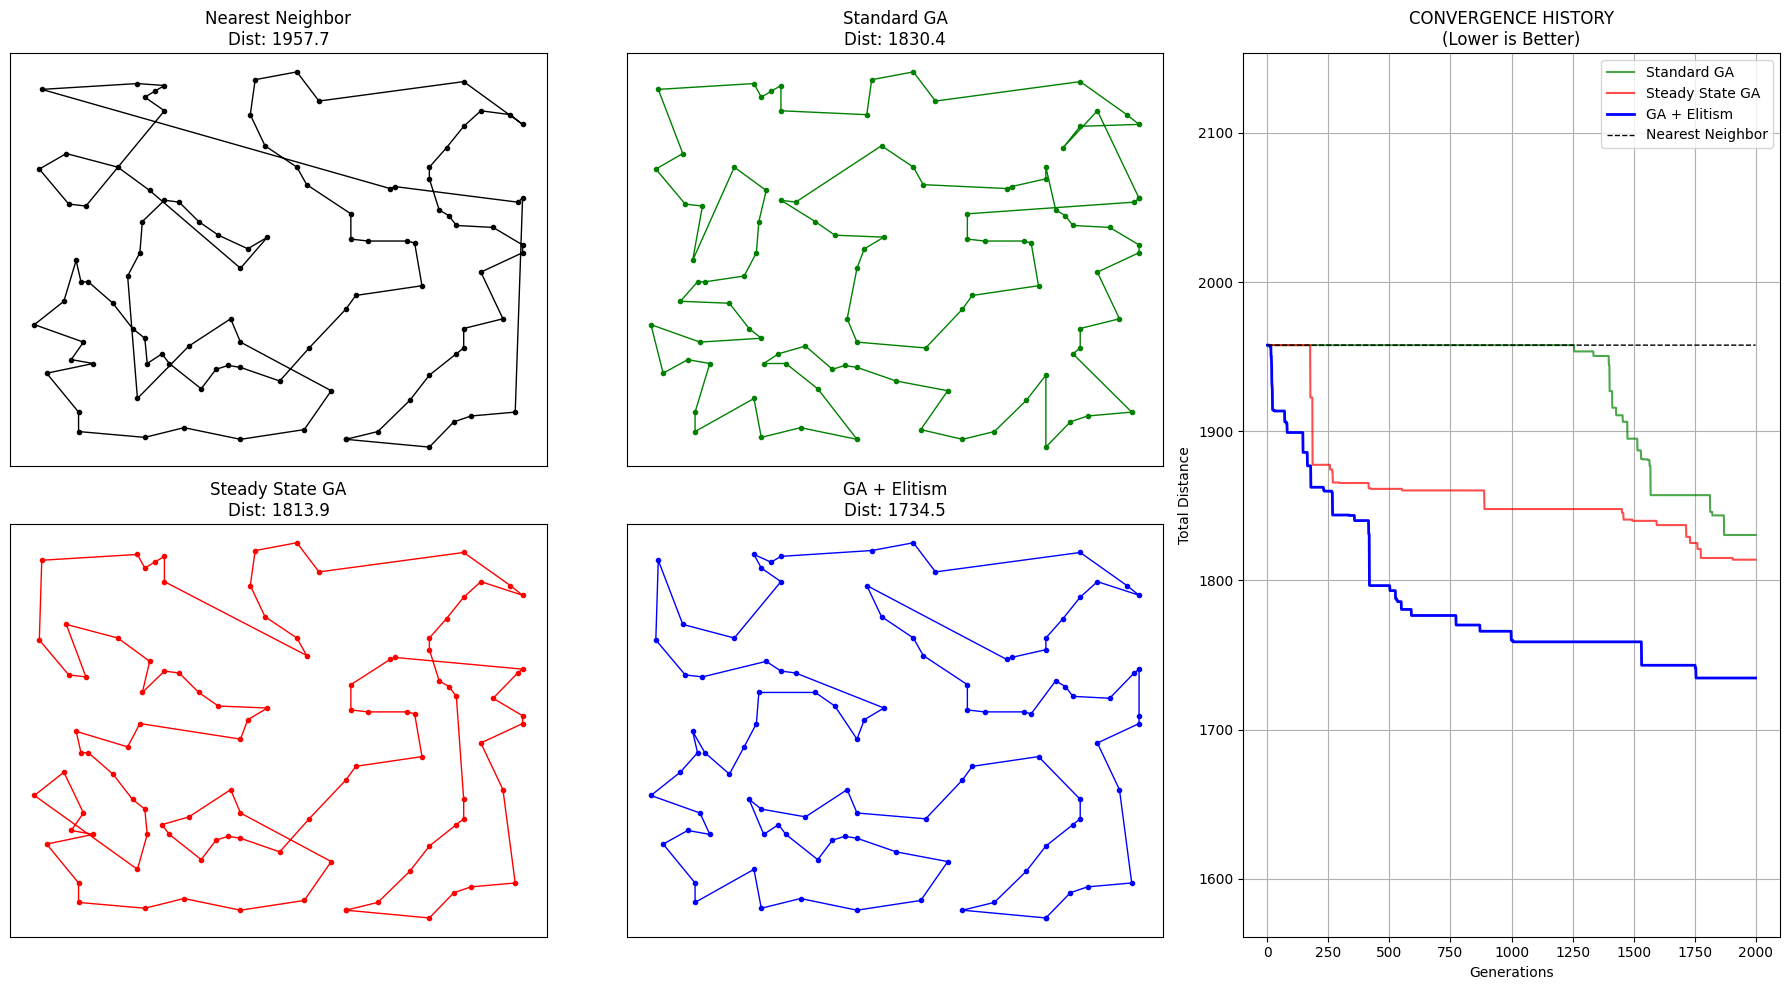

In [9]:
# [CELL 9] MAIN EXECUTION
# ---------------------------------------------------------
# Chạy chương trình.
run_fast_comparison()